# Time-varying Inference Analysis

Analysis of model's probabilities w.r.t. input lenght and zero-padding insertion

In [ ]:
# REQUIRED FOR GOOGLE COLAB STANDALONE RUNTIMES
#!pip install epanns-inference  
#!git clone https://github.com/StefanoGiacomelli/e2panns.git
#%cd ./e2panns/

In [2]:
import os
from pathlib import Path
import csv
import random
from tqdm import tqdm
import soundfile as sf
import numpy as np
import torch
from epanns_inference import models
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', size=12)
from IPython.display import Audio

# Set seeds
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Auxiliary functions

## Model Checkpoint Loading

In [4]:
def load_lightning2pt(checkpoint_path, model, device="cpu", verbose=True, validate_updates=True):
    """
    Loads a PyTorch Lightning checkpoint's state_dict into a plain PyTorch model and optionally verifies parameter updates.

    :param checkpoint_path: Absolute Path to the Lightning checkpoint file (.ckpt).
    :param model: The plain PyTorch model instance to load the checkpoint into.
    :param device: Device to load the model onto ('cpu' or 'cuda').
    :param verbose: Whether to print detailed information about the loading process (default: True).
    :param validate_updates: Whether to validate which layers were updated during fine-tuning (default: True).
    :return: The plain PyTorch model with weights loaded from the checkpoint, and a list of updated layers (if validated).
    """
    # Step 1: Load the Lightning checkpoint
    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
    except FileNotFoundError:
        raise ValueError(f"Checkpoint file not found at: {checkpoint_path}")
    except Exception as e:
        raise ValueError(f"Failed to load checkpoint: {e}")

    # Step 2: Extract the Lightning state_dict
    if "state_dict" not in checkpoint:
        raise ValueError(f"Checkpoint does not contain a 'state_dict'. Keys found: {list(checkpoint.keys())}")

    lightning_state_dict = checkpoint["state_dict"]

    # Step 3: Generalize prefix removal
    stripped_state_dict = {}
    prefix = None

    for key in lightning_state_dict.keys():
        if "." in key:
            prefix = key.split(".")[0] + "."
            break

    if prefix:
        stripped_state_dict = {key.replace(prefix, ""): value for key, value in lightning_state_dict.items()}
        if verbose:
            print(f"Detected prefix '{prefix}'. Stripped from state_dict keys.")
    else:
        stripped_state_dict = lightning_state_dict
        if verbose:
            print("No prefix detected in state_dict keys.")

    # Step 4: Move the model to the specified device
    model.to(device)
    if verbose:
        print(f"Model moved to device: {device}")

    # Step 5: Optionally validate parameter updates
    updated_layers = []
    if validate_updates:
        for name, param in model.state_dict().items():
            if name in stripped_state_dict:
                old_param = param.clone()
                new_param = stripped_state_dict[name]

                # Print data type information
                if verbose:
                    print(f"Validating layer: {name}")
                    print(f"  Old Param: Type: {type(old_param)}, DType: {old_param.dtype}")
                    print(f"  New Param: Type: {type(new_param)}, DType: {new_param.dtype}")

                # Compare old and new parameters
                if not torch.equal(old_param, new_param):
                    updated_layers.append(name)

                    # Compute and display parameter differences
                    diff = (old_param - new_param).float()
                    if verbose:
                        print(f"  Layer: {name} has changes!")
                        print(f"    Min Difference: {diff.abs().min().item():.6f}")
                        print(f"    Max Difference: {diff.abs().max().item():.6f}")
                        print(f"    Mean Difference: {diff.abs().mean().item():.6f}")
                        print(f"    Std-Dev of Differences: {diff.abs().std().item():.6f}")

                        # Optionally, display a small set of differences
                        print(f"    Sample Differences: {diff.flatten()[:5].tolist()}...")
                print('---------------------------------------------------------------------------------')

    # Load the stripped state_dict into the plain model
    try:
        model.load_state_dict(stripped_state_dict)
        if verbose:
            print("State dict successfully loaded into the model!")
    except Exception as e:
        raise ValueError(f"Failed to load state_dict into the model: {e}")

    # Step 6: Print updated layers if validated
    if verbose and validate_updates:
        if updated_layers:
            print("The following layers were updated during fine-tuning:")
            for layer in updated_layers:
                print(f" - {layer}")
        else:
            print("No layers were updated. Fine-tuning may not have modified the model.")

    # Return the model and optionally updated layers
    return model, updated_layers if validate_updates else None

## Audio samples reading

In [5]:
def load_samps_probs(base_dir, group_name: str, yt_ids: list, csv_filename, class_idx: int = 322, verbose=True):
    """
    Load audio files and associated probabilities for a given list of YouTube IDs.

    :param group_name: Name of the directory under base_directory containing the audio samples (a.k.a.: TX_NN or TX_MISS).
    :param yt_ids: List of YouTube IDs to match with audio files and model inference CSV summary file.
    :param base_dir: Absolute Path to the directory containing data files (e.g.: 'selected_dataset').
    :param csv_filename: filename of CSV containing probabilities (w. extension).
    :param class_idx: Index of the AudioSet class for probabilities CSV retrieval.
    :param verbose: Boolean flag to enable or disable console prints.
    :return: Tuple (audio_data, model_probs)
             - audio_data: List of ordered NumPy arrays (audio samples).
             - model_probs: List of ordered probabilities (inf_probability[class_idx]).
    """
    # Directory corresponding to the list
    list_directory = os.path.join(base_dir, f'{group_name}/')
    if not os.path.isdir(list_directory):
        raise FileNotFoundError(f"Group directory '{group_name}' not found in {base_dir}")

    # Step 1: Load audio files
    audio_data = []
    for yt_id in yt_ids:
        # Find all files in the list directory starting with the current yt_id
        matching_files = [f for f in os.listdir(list_directory) if f.startswith(yt_id)]
        if not matching_files:
            raise FileNotFoundError(f"No audio files found for yt_id='{yt_id}' in {list_directory}")

        # Load the first matching file (if multiple, we pick the first)
        matching_files.sort()  # Sort to ensure consistent order if multiple matches exist
        file_path = os.path.join(list_directory, matching_files[0])
        audio, sample_rate = sf.read(file_path)
        if audio.ndim > 1:
            audio = audio.squeeze()  # Squeeze channel dim
        if sample_rate != 32000:
            print(f'Warning! Sample rate: {sample_rate}Hz')

        # Store the audio array
        audio_data.append(audio)
        if verbose:
            print(f"Loaded '{file_path}' for yt_id '{yt_id}', Shape: {audio.shape}, Sample Rate: {sample_rate}")

    # Step 2: Load the CSV and retrieve probabilities
    model_probs = []
    with open(os.path.join(base_dir, f'{csv_filename}'), mode='r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        yt_id_to_prob = {row['yt_id']: float(row[f'inf_probability[{class_idx}]']) for row in reader}

    # Retrieve probabilities in the same order as the youtube_ids list
    for yt_id in yt_ids:
        if yt_id not in yt_id_to_prob:
            raise ValueError(f"yt_id '{yt_id}' not found in CSV.")
        model_probs.append(yt_id_to_prob[yt_id])
        if verbose:
            print(f"yt_id '{yt_id}' -> Probability[{class_idx}]: {yt_id_to_prob[yt_id]}")

    return audio_data, model_probs

# Model Set-Up

In [ ]:
SAMPLING_RATE = 32000   #Hz
DEVICE = "cpu"
CWD_PATH = Path.cwd()
CHECKPOINT_PATH = CWD_PATH / "checkpoints/epoch=0_epoch_val_accuracy=0.8454.ckpt"

original_model = models.Cnn14_pruned(pre_trained=True)
print("\n" * 5, end="")
model, updated_layers = load_lightning2pt(checkpoint_path=CHECKPOINT_PATH,
                                          model=original_model,
                                          device=DEVICE,
                                          verbose=True,
                                          validate_updates=True)

# Experiments

1. Inference on progressively BIGGER segments (No-padding)
2. Inference on progressively BIGGER segments (Causal 0-padding to 10sec.)
3. Re-iterated Random inference on **Best Trade-off Size/Accuracy** segments (No-padding)
4. Re-iterated Random inference on **Best Trade-off Size/Accuracy** segments (Positional-dependent 0-padding to 10sec.)

In [ ]:
%cd './embedding/audio_files/analysis_dataset/'
!ls

## TPs (p >= 95%)

In [9]:
# Parameters
GROUP_NAME = 'TP_95'
TP_95 = ['rd6ABrc741A', 'Gu6YAcG9s4c', 'D05-MrPXqjw', '71gT3JjlrfU', 'mwdhs5OvEpY']
CLASS_INDEX = 322
SEGMENT_SIZES = [10., 9., 7.5, 5., 2.5, 1., 0.5, 0.31]                          # sec.
batch_size = len(TP_95)
size_samps = [int(size * SAMPLING_RATE) for size in SEGMENT_SIZES]

# Load audio samples
batch_samples, finetune_probs = load_samps_probs(base_dir=os.path.abspath('./'),
                                                 group_name=GROUP_NAME,
                                                 yt_ids=TP_95,
                                                 csv_filename='selected_samples.csv',
                                                 class_idx=CLASS_INDEX,
                                                 verbose=True)

Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_95/rd6ABrc741A_Original.wav' for yt_id 'rd6ABrc741A', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_95/Gu6YAcG9s4c_Original.wav' for yt_id 'Gu6YAcG9s4c', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_95/D05-MrPXqjw_Original.wav' for yt_id 'D05-MrPXqjw', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_95/71gT3JjlrfU_Original.wav' for yt_id '71gT3JjlrfU', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_95/mwdhs5OvEpY_Original.wav' for yt_id 'mwdhs5OvEpY', Shape: (320000,), Sample Rate: 3

In [14]:
# Select sample to playback (0 - 4)
playback_idx = 0
Audio(batch_samples[playback_idx], rate=SAMPLING_RATE, normalize=False)

**dubbi sul campione 2**

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:02<00:09,  2.40s/sample]


Processing Samples:  40%|████      | 2/5 [00:04<00:06,  2.24s/sample]


Processing Samples:  60%|██████    | 3/5 [00:06<00:04,  2.20s/sample]


Processing Samples:  80%|████████  | 4/5 [00:08<00:02,  2.17s/sample]


Processing Samples: 100%|██████████| 5/5 [00:11<00:00,  2.38s/sample]


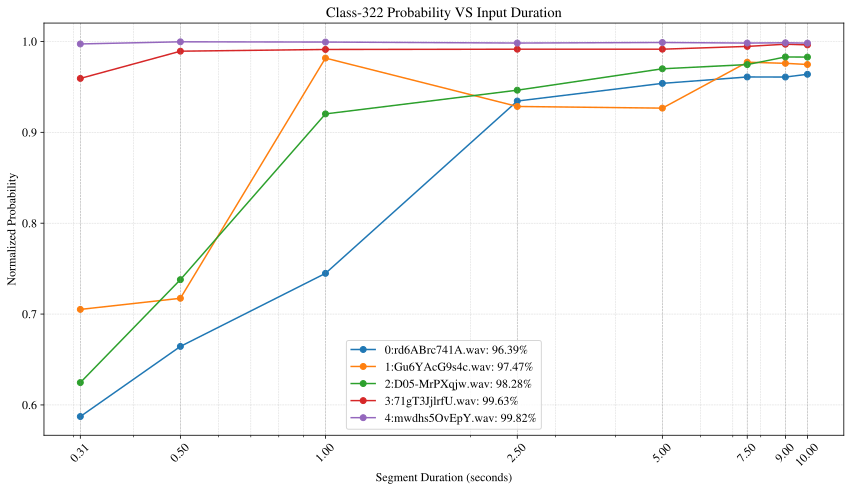

In [11]:
# Experiment 1
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0: segment_size]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{sample_id}:{TP_95[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_1_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_1_{GROUP_NAME}.svg", format="svg")
plt.show()

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:06<00:25,  6.49s/sample]


Processing Samples:  40%|████      | 2/5 [00:11<00:17,  5.85s/sample]


Processing Samples:  60%|██████    | 3/5 [00:20<00:13,  6.95s/sample]


Processing Samples:  80%|████████  | 4/5 [00:25<00:06,  6.43s/sample]


Processing Samples: 100%|██████████| 5/5 [00:32<00:00,  6.55s/sample]


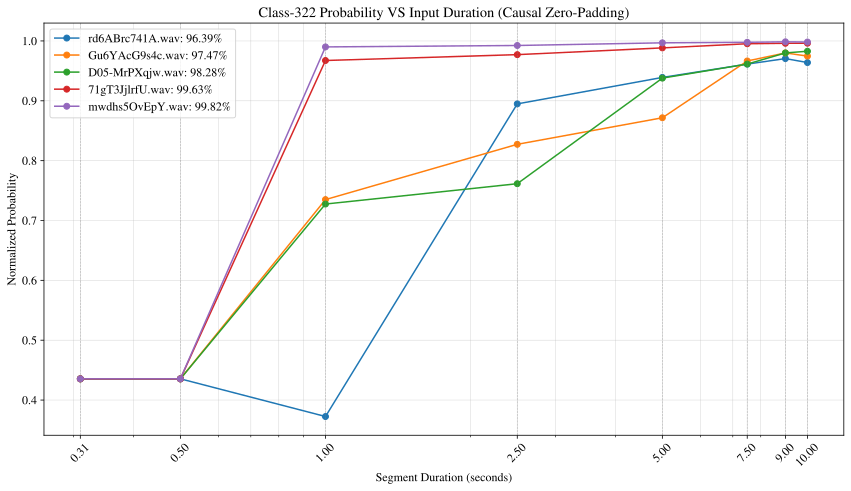

In [19]:
# Experiment 2
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0:segment_size]

        # Apply causal zero-padding to 10 seconds
        padding_size = (SAMPLING_RATE * 10) - segment_size
        if padding_size > 0:
            segment = np.pad(segment, (0, padding_size))
        else:
            segment = segment[:SAMPLING_RATE * 10]                              # Trim if segment exceeds 10 seconds

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TP_95[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration (Causal Zero-Padding)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_2_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_2_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples:   0%|          | 0/5 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))
Processing Samples: 100%|██████████| 5/5 [00:10<00:00,  2.06s/sample]


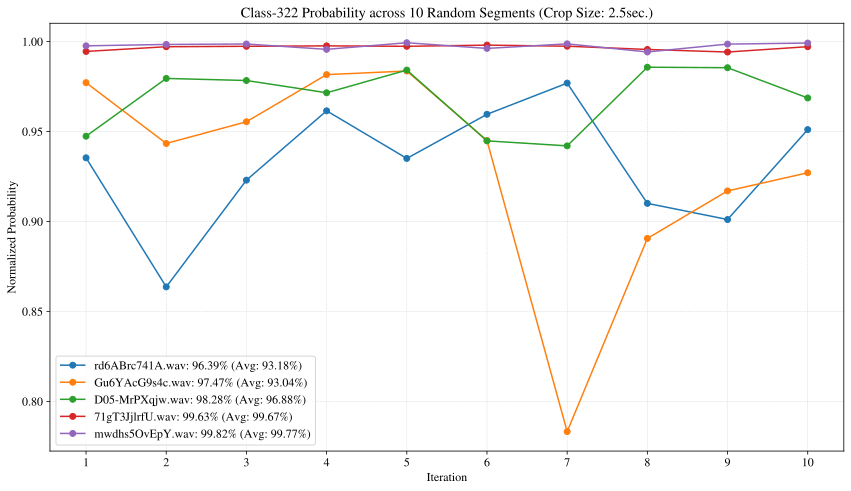

In [20]:
# Experiment 3
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        segment = sample[start_idx:start_idx + crop_size_samples]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TP_95[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, 11))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_3_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_3_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples: 100%|██████████| 5/5 [00:40<00:00,  8.06s/sample]


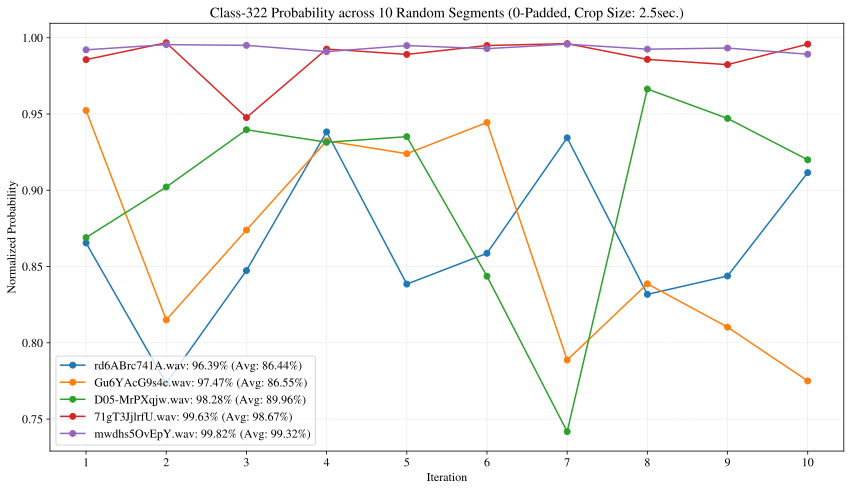

In [21]:
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        end_idx = start_idx + crop_size_samples

        # Extract the segment
        segment = sample[start_idx:end_idx]

        # Create a 10-second array filled with zeros
        zero_padded_array = np.zeros(sample_length, dtype=sample.dtype)

        # Insert the segment into the zero-padded array at the original position
        zero_padded_array[start_idx:end_idx] = segment

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(zero_padded_array).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TP_95[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, NUM_SEGMENTS + 1))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (0-Padded, Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_4_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_4_{GROUP_NAME}.svg", format="svg")
plt.show()

## TPs (75% < p < 90%)

In [15]:
# Parameters
GROUP_NAME = 'TP_90_75'
TP_90_75 = ['eLLsOzuTt8s', 'i-gsEmy7_lE', 'rCQykaL8Hy4', 'zokwx1WRdrc', 'wsn3kF5sjj8']
CLASS_INDEX = 322
SEGMENT_SIZES = [10., 9., 7.5, 5., 2.5, 1., 0.5, 0.31]                          # sec.
batch_size = len(TP_90_75)
size_samps = [int(size * SAMPLING_RATE) for size in SEGMENT_SIZES]

# Load audio samples
batch_samples, finetune_probs = load_samps_probs(base_dir=os.path.abspath('./'),
                                                 group_name=GROUP_NAME,
                                                 yt_ids=TP_90_75,
                                                 csv_filename='selected_samples.csv',
                                                 class_idx=CLASS_INDEX,
                                                 verbose=True)

Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_90_75/eLLsOzuTt8s_Original.wav' for yt_id 'eLLsOzuTt8s', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_90_75/i-gsEmy7_lE_Original.wav' for yt_id 'i-gsEmy7_lE', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_90_75/rCQykaL8Hy4_Original.wav' for yt_id 'rCQykaL8Hy4', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_90_75/zokwx1WRdrc_Original.wav' for yt_id 'zokwx1WRdrc', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_90_75/wsn3kF5sjj8_Original.wav' for yt_id 'wsn3kF5sjj8', Shape: (320000,),

In [23]:
# Select sample to playback (0 - 4)
playback_idx = 0
Audio(batch_samples[playback_idx], rate=SAMPLING_RATE, normalize=False)

**campioni già molto "cattivi": disturbati, riverberati...**

il 3 è pessimo:  si sente una sirena solo per un secondo a 0:07

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:05<00:22,  5.56s/sample]


Processing Samples:  40%|████      | 2/5 [00:09<00:14,  4.77s/sample]


Processing Samples:  60%|██████    | 3/5 [00:12<00:07,  3.87s/sample]


Processing Samples:  80%|████████  | 4/5 [00:14<00:03,  3.18s/sample]


Processing Samples: 100%|██████████| 5/5 [00:17<00:00,  3.47s/sample]


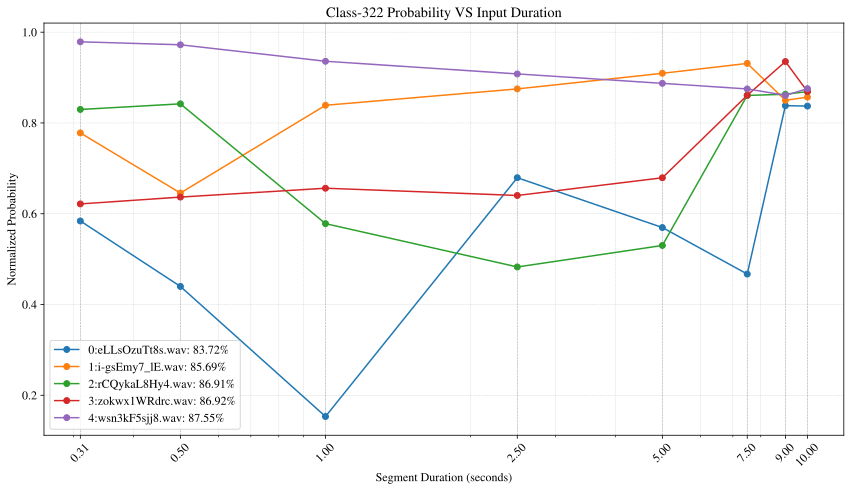

In [17]:
# Experiment 1
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0: segment_size]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{sample_id}:{TP_90_75[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_1_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_1_{GROUP_NAME}.svg", format="svg")
plt.show()

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:06<00:26,  6.65s/sample]


Processing Samples:  40%|████      | 2/5 [00:11<00:16,  5.51s/sample]


Processing Samples:  60%|██████    | 3/5 [00:16<00:10,  5.39s/sample]


Processing Samples:  80%|████████  | 4/5 [00:22<00:05,  5.57s/sample]


Processing Samples: 100%|██████████| 5/5 [00:27<00:00,  5.42s/sample]


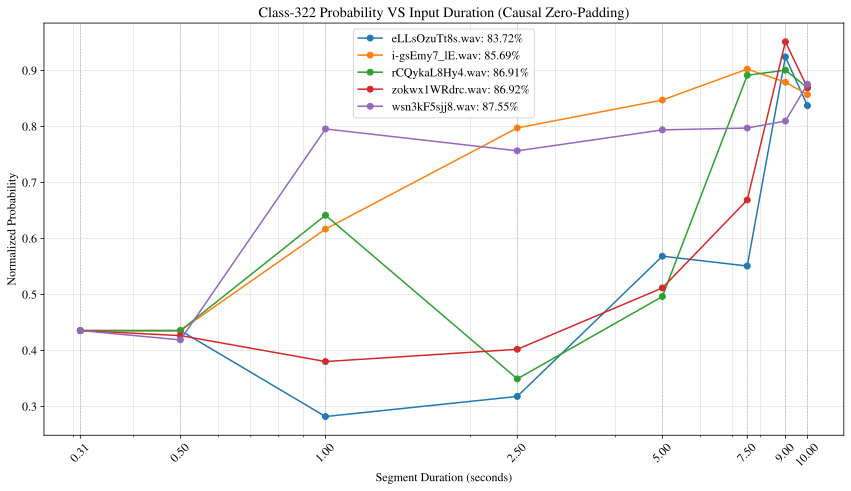

In [22]:
# Experiment 2
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0:segment_size]

        # Apply causal zero-padding to 10 seconds
        padding_size = (SAMPLING_RATE * 10) - segment_size
        if padding_size > 0:
            segment = np.pad(segment, (0, padding_size))
        else:
            segment = segment[:SAMPLING_RATE * 10]                              # Trim if segment exceeds 10 seconds

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TP_90_75[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration (Causal Zero-Padding)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_2_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_2_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples:   0%|          | 0/5 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))
Processing Samples: 100%|██████████| 5/5 [00:08<00:00,  1.72s/sample]


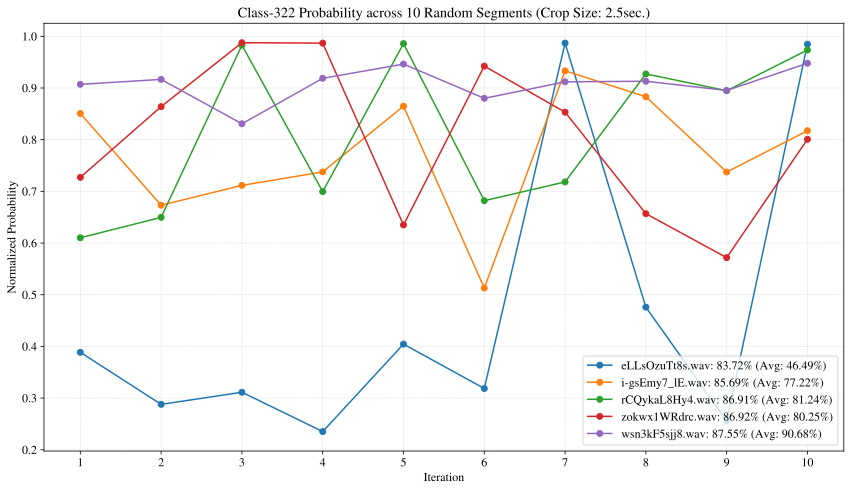

In [11]:
# Experiment 3
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        segment = sample[start_idx:start_idx + crop_size_samples]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TP_90_75[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, 11))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_3_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_3_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples: 100%|██████████| 5/5 [00:31<00:00,  6.35s/sample]


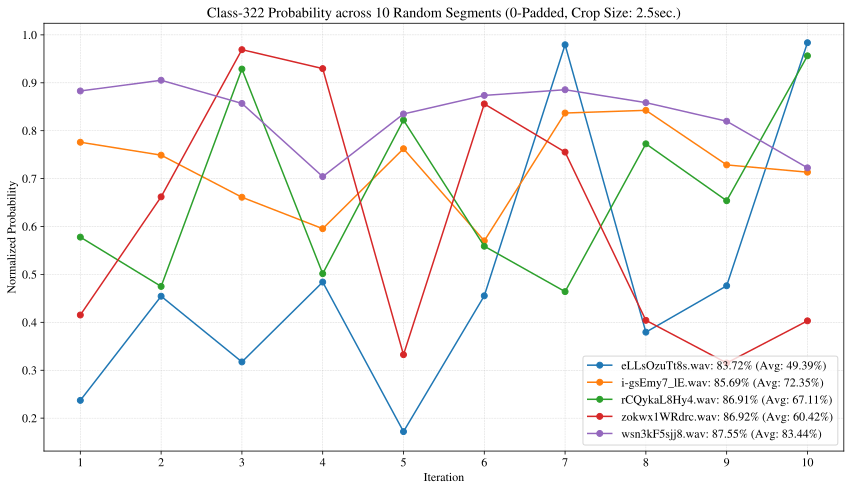

In [12]:
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        end_idx = start_idx + crop_size_samples

        # Extract the segment
        segment = sample[start_idx:end_idx]

        # Create a 10-second array filled with zeros
        zero_padded_array = np.zeros(sample_length, dtype=sample.dtype)

        # Insert the segment into the zero-padded array at the original position
        zero_padded_array[start_idx:end_idx] = segment

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(zero_padded_array).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TP_90_75[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, NUM_SEGMENTS + 1))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (0-Padded, Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_4_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_4_{GROUP_NAME}.svg", format="svg")
plt.show()

## TPs (51% < p < 74%)

In [24]:
# Parameters
GROUP_NAME = 'TP_74_51'
TP_74_51 = ['6rXgD5JlYxY', 'WqilmDhc5Xo', 'dqhn-3c21mU', '-ZjtUhLYB3w', '8mvddTw8eGM']
CLASS_INDEX = 322
SEGMENT_SIZES = [10., 9., 7.5, 5., 2.5, 1., 0.5, 0.31]                          # sec.
batch_size = len(TP_74_51)
size_samps = [int(size * SAMPLING_RATE) for size in SEGMENT_SIZES]

# Load audio samples
batch_samples, finetune_probs = load_samps_probs(base_dir=os.path.abspath('./'),
                                                 group_name=GROUP_NAME,
                                                 yt_ids=TP_74_51,
                                                 csv_filename='selected_samples.csv',
                                                 class_idx=CLASS_INDEX,
                                                 verbose=True)

Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_74_51/6rXgD5JlYxY_Original.wav' for yt_id '6rXgD5JlYxY', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_74_51/WqilmDhc5Xo_Original.wav' for yt_id 'WqilmDhc5Xo', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_74_51/dqhn-3c21mU_Original.wav' for yt_id 'dqhn-3c21mU', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_74_51/-ZjtUhLYB3w_Original.wav' for yt_id '-ZjtUhLYB3w', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_74_51/8mvddTw8eGM_Original.wav' for yt_id '8mvddTw8eGM', Shape: (320000,),

In [30]:
# Select sample to playback (0 - 4)
playback_idx = 4
Audio(batch_samples[playback_idx], rate=SAMPLING_RATE, normalize=False)

**Ispezione uditiva dei campioni**

0 non sento sirene o EV (misclassified?)

1 gli ultimi due secondi sembra una sirena che si sta avviando

2 non sento sirene o EV (misclassified?)

3 sirena molto lontana

4 non sento sirene o EV (misclassified?)

Processing Samples:  20%|██        | 1/5 [00:05<00:22,  5.72s/sample]


Processing Samples:  40%|████      | 2/5 [00:12<00:19,  6.41s/sample]


Processing Samples:  60%|██████    | 3/5 [00:16<00:10,  5.15s/sample]


Processing Samples:  80%|████████  | 4/5 [00:18<00:03,  3.97s/sample]


Processing Samples: 100%|██████████| 5/5 [00:20<00:00,  4.12s/sample]


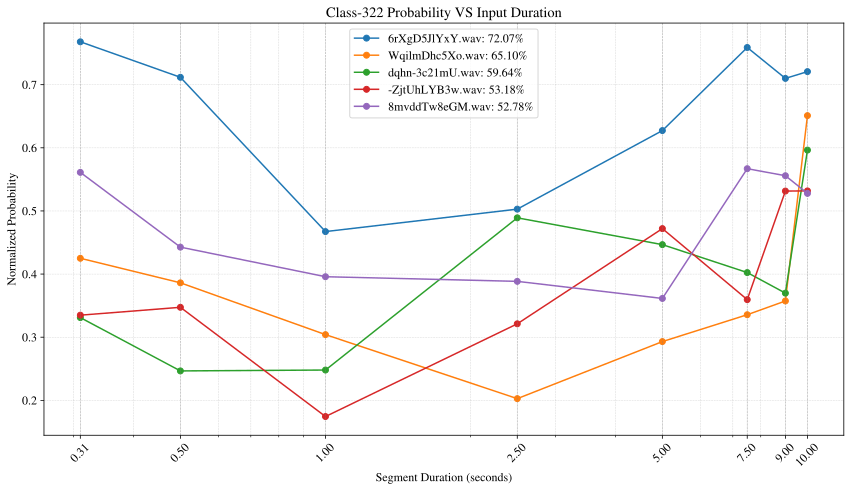

In [19]:
# Experiment 1
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0: segment_size]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TP_74_51[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_1_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_1_{GROUP_NAME}.svg", format="svg")
plt.show()

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:06<00:27,  6.79s/sample]


Processing Samples:  40%|████      | 2/5 [00:11<00:16,  5.59s/sample]


Processing Samples:  60%|██████    | 3/5 [00:16<00:10,  5.46s/sample]


Processing Samples:  80%|████████  | 4/5 [00:23<00:05,  5.74s/sample]


Processing Samples: 100%|██████████| 5/5 [00:27<00:00,  5.56s/sample]


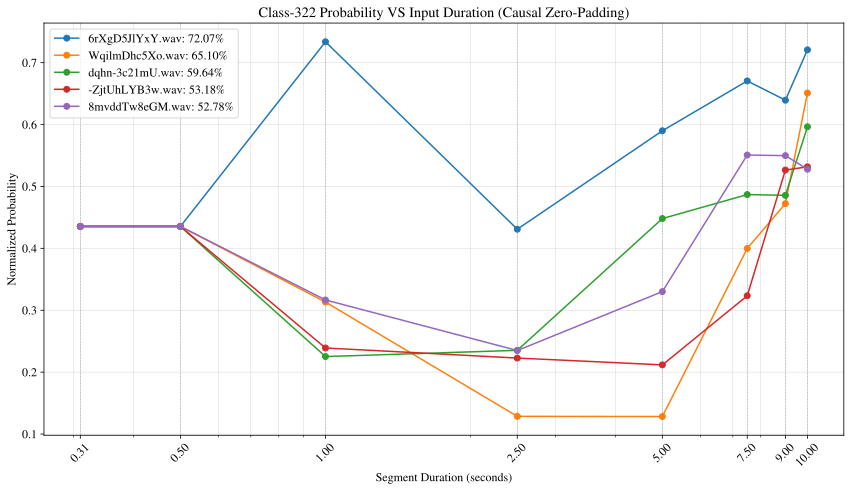

In [20]:
# Experiment 2
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0:segment_size]

        # Apply causal zero-padding to 10 seconds
        padding_size = (SAMPLING_RATE * 10) - segment_size
        if padding_size > 0:
            segment = np.pad(segment, (0, padding_size))
        else:
            segment = segment[:SAMPLING_RATE * 10]                              # Trim if segment exceeds 10 seconds

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TP_74_51[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration (Causal Zero-Padding)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_2_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_2_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples:   0%|          | 0/5 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))
Processing Samples: 100%|██████████| 5/5 [00:06<00:00,  1.40s/sample]


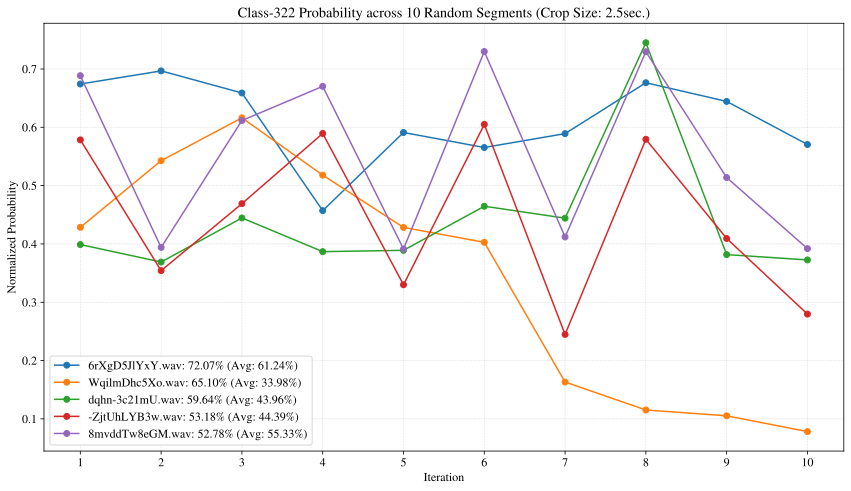

In [21]:
# Experiment 3
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        segment = sample[start_idx:start_idx + crop_size_samples]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TP_74_51[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, 11))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_3_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_3_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples: 100%|██████████| 5/5 [00:32<00:00,  6.47s/sample]


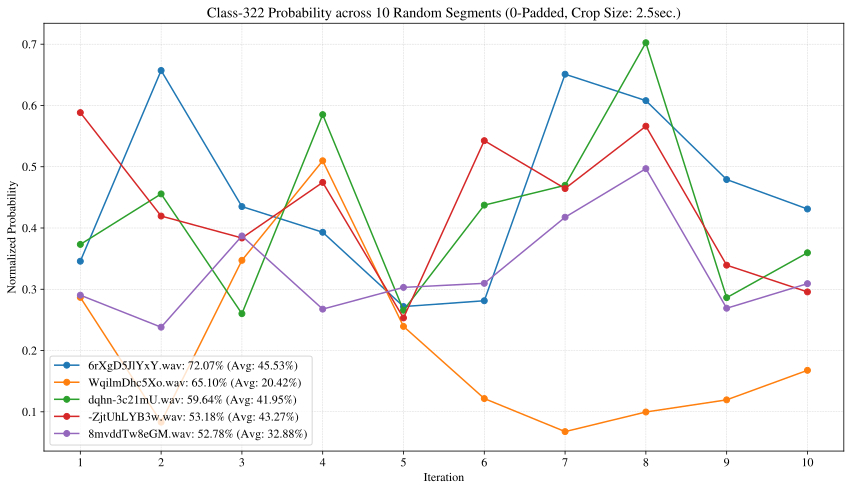

In [22]:
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        end_idx = start_idx + crop_size_samples

        # Extract the segment
        segment = sample[start_idx:end_idx]

        # Create a 10-second array filled with zeros
        zero_padded_array = np.zeros(sample_length, dtype=sample.dtype)

        # Insert the segment into the zero-padded array at the original position
        zero_padded_array[start_idx:end_idx] = segment

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(zero_padded_array).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TP_74_51[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, NUM_SEGMENTS + 1))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (0-Padded, Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_4_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_4_{GROUP_NAME}.svg", format="svg")
plt.show()

## TPs MISS (p < 50%)

In [31]:
# Parameters
GROUP_NAME = 'TP_MISS'
TP_MISS = ['x7rR7s-o73s', '1_3HW1jnI6w', 'iE8pSulXDuc', '6AurbZcj3Es', 'vfUgQTKgKDI']
CLASS_INDEX = 322
SEGMENT_SIZES = [10., 9., 7.5, 5., 2.5, 1., 0.5, 0.31]                          # sec.
batch_size = len(TP_MISS)
size_samps = [int(size * SAMPLING_RATE) for size in SEGMENT_SIZES]

# Load audio samples
batch_samples, finetune_probs = load_samps_probs(base_dir=os.path.abspath('./'),
                                                 group_name=GROUP_NAME,
                                                 yt_ids=TP_MISS,
                                                 csv_filename='selected_samples.csv',
                                                 class_idx=CLASS_INDEX,
                                                 verbose=True)

Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_MISS/x7rR7s-o73s_Original.wav' for yt_id 'x7rR7s-o73s', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_MISS/1_3HW1jnI6w_Original.wav' for yt_id '1_3HW1jnI6w', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_MISS/iE8pSulXDuc_Original.wav' for yt_id 'iE8pSulXDuc', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_MISS/6AurbZcj3Es_Original.wav' for yt_id '6AurbZcj3Es', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TP_MISS/vfUgQTKgKDI_Original.wav' for yt_id 'vfUgQTKgKDI', Shape: (320000,), Samp

In [34]:
# Select sample to playback (0 - 4)
playback_idx = 2
Audio(batch_samples[playback_idx], rate=SAMPLING_RATE, normalize=False)

**Ispezione uditiva**

0 non è sirena né EV

1 non è sirena né EV

2 non è sirena né EV

3 non è sirena né EV

4 non è sirena né EV

Processing Samples:  20%|██        | 1/5 [00:02<00:11,  2.89s/sample]


Processing Samples:  40%|████      | 2/5 [00:06<00:09,  3.03s/sample]


Processing Samples:  60%|██████    | 3/5 [00:08<00:05,  2.78s/sample]


Processing Samples:  80%|████████  | 4/5 [00:11<00:03,  3.03s/sample]


Processing Samples: 100%|██████████| 5/5 [00:14<00:00,  2.86s/sample]


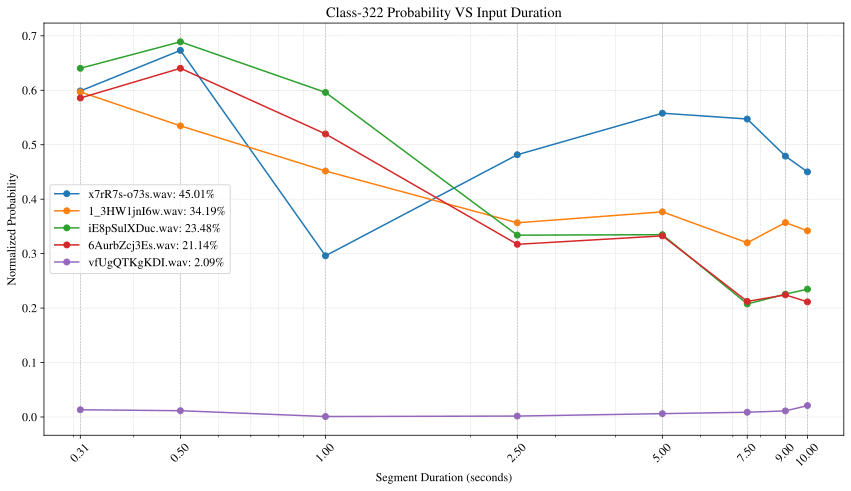

In [29]:
# Experiment 1
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0: segment_size]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TP_MISS[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_1_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_1_{GROUP_NAME}.svg", format="svg")
plt.show()

# Questo risultato è problematico perché per certi segmenti si ottengono dei falsi positivi

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:04<00:18,  4.74s/sample]


Processing Samples:  40%|████      | 2/5 [00:09<00:14,  4.80s/sample]


Processing Samples:  60%|██████    | 3/5 [00:15<00:11,  5.52s/sample]


Processing Samples:  80%|████████  | 4/5 [00:20<00:05,  5.23s/sample]


Processing Samples: 100%|██████████| 5/5 [00:26<00:00,  5.26s/sample]


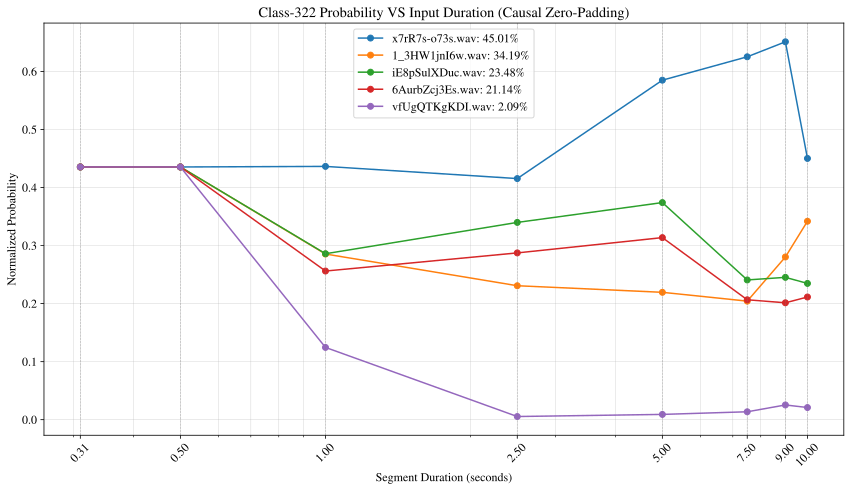

In [30]:
# Experiment 2
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0:segment_size]

        # Apply causal zero-padding to 10 seconds
        padding_size = (SAMPLING_RATE * 10) - segment_size
        if padding_size > 0:
            segment = np.pad(segment, (0, padding_size))
        else:
            segment = segment[:SAMPLING_RATE * 10]                              # Trim if segment exceeds 10 seconds

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TP_MISS[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration (Causal Zero-Padding)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_2_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_2_{GROUP_NAME}.svg", format="svg")
plt.show()

# Nel problema dei falsi positivi, lo zero-padding sembra aumentare la robustezza

Processing Samples:   0%|          | 0/5 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))
Processing Samples: 100%|██████████| 5/5 [00:07<00:00,  1.44s/sample]


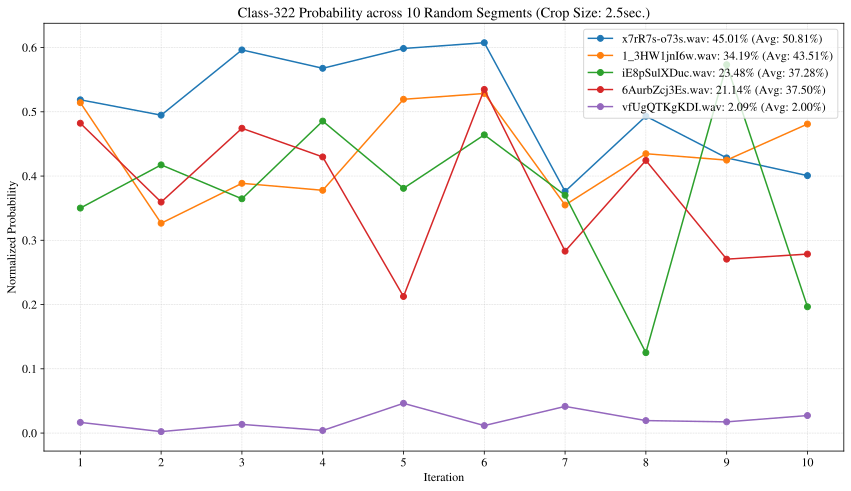

In [31]:
# Experiment 3
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        segment = sample[start_idx:start_idx + crop_size_samples]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TP_MISS[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, 11))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_3_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_3_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples: 100%|██████████| 5/5 [00:32<00:00,  6.50s/sample]


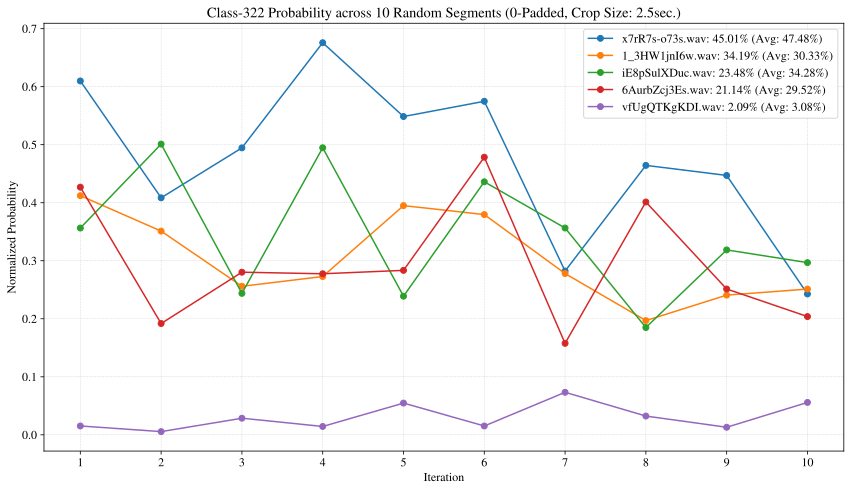

In [33]:
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        end_idx = start_idx + crop_size_samples

        # Extract the segment
        segment = sample[start_idx:end_idx]

        # Create a 10-second array filled with zeros
        zero_padded_array = np.zeros(sample_length, dtype=sample.dtype)

        # Insert the segment into the zero-padded array at the original position
        zero_padded_array[start_idx:end_idx] = segment

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(zero_padded_array).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TP_MISS[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, NUM_SEGMENTS + 1))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (0-Padded, Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_4_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_4_{GROUP_NAME}.svg", format="svg")
plt.show()

## TNs (0% < p < 10%)

In [36]:
# Parameters
GROUP_NAME = 'TN_0_10'
TN_0_10 = ['-D28naXkUAA', '0siiq358HAQ', '2YObUMad3Bc', '2TiBGRSiKvg', '-6TmgHPt5hs']
CLASS_INDEX = 322
SEGMENT_SIZES = [10., 9., 7.5, 5., 2.5, 1., 0.5, 0.31]                          # sec.
batch_size = len(TN_0_10)
size_samps = [int(size * SAMPLING_RATE) for size in SEGMENT_SIZES]

# Load audio samples
batch_samples, finetune_probs = load_samps_probs(base_dir=os.path.abspath('./'),
                                                 group_name=GROUP_NAME,
                                                 yt_ids=TN_0_10,
                                                 csv_filename='selected_samples.csv',
                                                 class_idx=CLASS_INDEX,
                                                 verbose=True)

Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_0_10/-D28naXkUAA_Original.wav' for yt_id '-D28naXkUAA', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_0_10/0siiq358HAQ_Original.wav' for yt_id '0siiq358HAQ', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_0_10/2YObUMad3Bc_Original.wav' for yt_id '2YObUMad3Bc', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_0_10/2TiBGRSiKvg_Original.wav' for yt_id '2TiBGRSiKvg', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_0_10/-6TmgHPt5hs_Original.wav' for yt_id '-6TmgHPt5hs', Shape: (320000,), Samp

In [38]:
# Select sample to playback (0 - 4)
playback_idx = 4
Audio(batch_samples[playback_idx], rate=SAMPLING_RATE, normalize=False)

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:02<00:11,  2.91s/sample]


Processing Samples:  40%|████      | 2/5 [00:05<00:07,  2.48s/sample]


Processing Samples:  60%|██████    | 3/5 [00:07<00:04,  2.35s/sample]


Processing Samples:  80%|████████  | 4/5 [00:09<00:02,  2.28s/sample]


Processing Samples: 100%|██████████| 5/5 [00:12<00:00,  2.47s/sample]


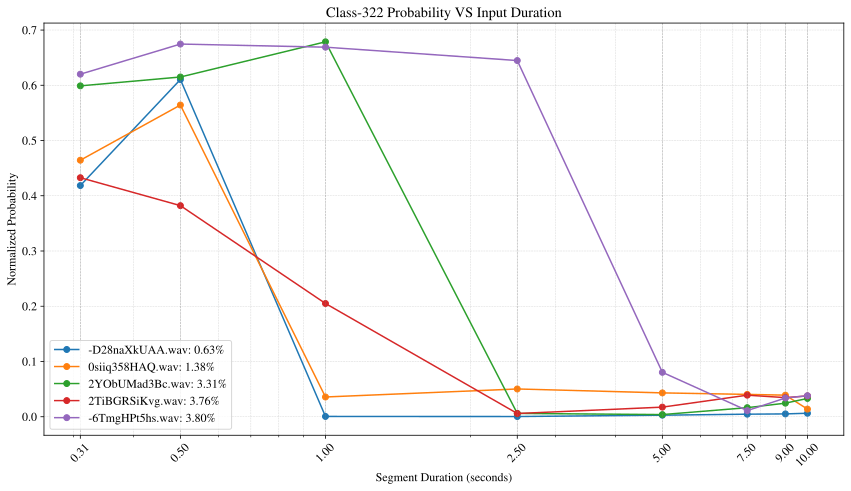

In [37]:
# Experiment 1
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0: segment_size]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TN_0_10[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_1_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_1_{GROUP_NAME}.svg", format="svg")
plt.show()

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:06<00:25,  6.45s/sample]


Processing Samples:  40%|████      | 2/5 [00:11<00:16,  5.42s/sample]


Processing Samples:  60%|██████    | 3/5 [00:16<00:10,  5.34s/sample]


Processing Samples:  80%|████████  | 4/5 [00:22<00:05,  5.53s/sample]


Processing Samples: 100%|██████████| 5/5 [00:26<00:00,  5.38s/sample]


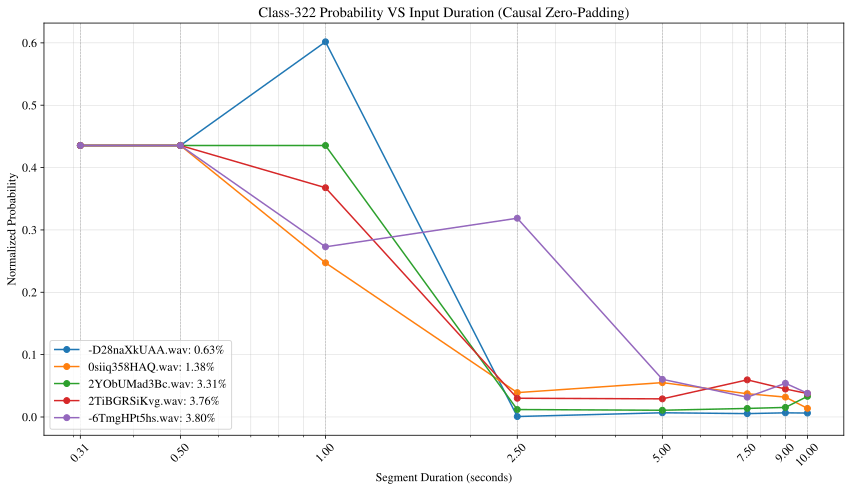

In [39]:
# Experiment 2
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0:segment_size]

        # Apply causal zero-padding to 10 seconds
        padding_size = (SAMPLING_RATE * 10) - segment_size
        if padding_size > 0:
            segment = np.pad(segment, (0, padding_size))
        else:
            segment = segment[:SAMPLING_RATE * 10]                              # Trim if segment exceeds 10 seconds

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TN_0_10[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration (Causal Zero-Padding)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_2_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_2_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples:   0%|          | 0/5 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))
Processing Samples: 100%|██████████| 5/5 [00:08<00:00,  1.68s/sample]


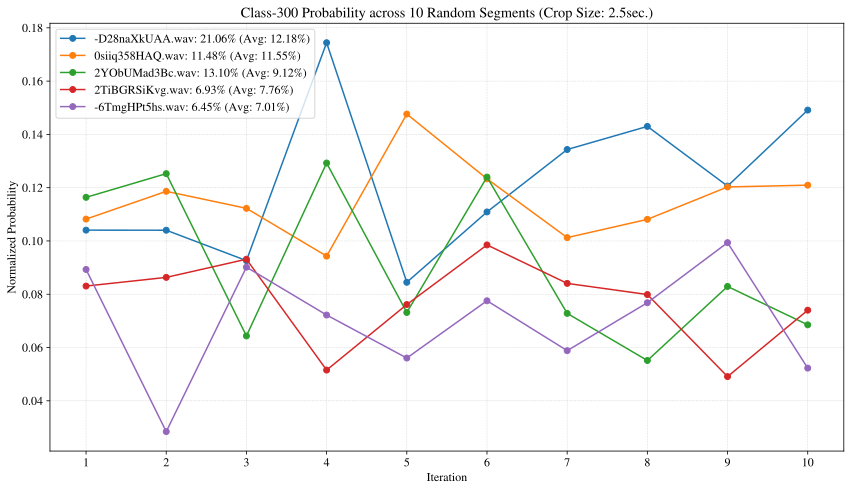

In [42]:
# Experiment 3
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        segment = sample[start_idx:start_idx + crop_size_samples]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TN_0_10[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, 11))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_3_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_3_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples: 100%|██████████| 5/5 [00:33<00:00,  6.69s/sample]


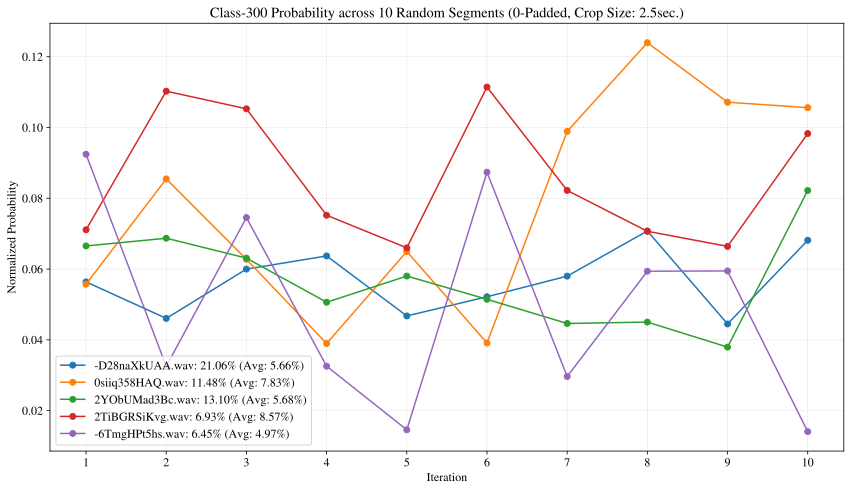

In [43]:
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        end_idx = start_idx + crop_size_samples

        # Extract the segment
        segment = sample[start_idx:end_idx]

        # Create a 10-second array filled with zeros
        zero_padded_array = np.zeros(sample_length, dtype=sample.dtype)

        # Insert the segment into the zero-padded array at the original position
        zero_padded_array[start_idx:end_idx] = segment

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(zero_padded_array).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TN_0_10[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, NUM_SEGMENTS + 1))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (0-Padded, Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_4_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_4_{GROUP_NAME}.svg", format="svg")
plt.show()

## TNs (20% < p < 30%)

In [44]:
# Parameters
GROUP_NAME = 'TN_20_30'
TN_20_30 = ['1xIoEndn2U4', '0I2sWpnBubk', '1RF4gg5LNqk', '0j6rg-m7C5g', 'axVAld8h_Lw']
CLASS_INDEX = 300
SEGMENT_SIZES = [10., 9., 7.5, 5., 2.5, 1., 0.5, 0.31]                          # sec.
batch_size = len(TN_20_30)
size_samps = [int(size * SAMPLING_RATE) for size in SEGMENT_SIZES]

# Load audio samples
batch_samples, finetune_probs = load_samps_probs(base_dir=os.path.abspath('./'),
                                                 group_name=GROUP_NAME,
                                                 yt_ids=TN_20_30,
                                                 csv_filename='selected_samples.csv',
                                                 class_idx=CLASS_INDEX,
                                                 verbose=True)

Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_20_30/1xIoEndn2U4_Original.wav' for yt_id '1xIoEndn2U4', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_20_30/0I2sWpnBubk_Original.wav' for yt_id '0I2sWpnBubk', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_20_30/1RF4gg5LNqk_Original.wav' for yt_id '1RF4gg5LNqk', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_20_30/0j6rg-m7C5g_Original.wav' for yt_id '0j6rg-m7C5g', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_20_30/axVAld8h_Lw_Original.wav' for yt_id 'axVAld8h_Lw', Shape: (320000,),

In [50]:
# Select sample to playback (0 - 4)
playback_idx = 4
Audio(batch_samples[playback_idx], rate=SAMPLING_RATE, normalize=False)

Processing Samples:  20%|██        | 1/5 [00:03<00:14,  3.74s/sample]


Processing Samples:  40%|████      | 2/5 [00:09<00:15,  5.22s/sample]


Processing Samples:  60%|██████    | 3/5 [00:16<00:11,  5.64s/sample]


Processing Samples:  80%|████████  | 4/5 [00:19<00:04,  4.87s/sample]


Processing Samples: 100%|██████████| 5/5 [00:23<00:00,  4.70s/sample]


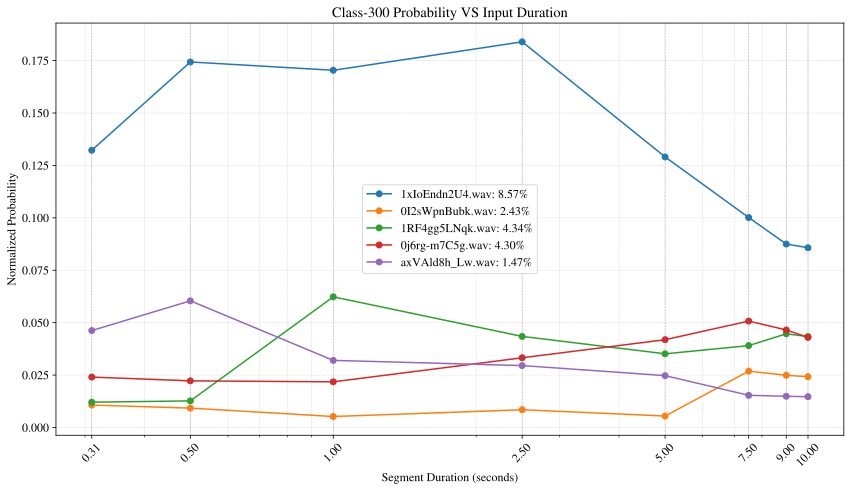

In [49]:
# Experiment 1
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0: segment_size]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TN_20_30[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_1_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_1_{GROUP_NAME}.svg", format="svg")
plt.show()

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:04<00:19,  4.76s/sample]


Processing Samples:  40%|████      | 2/5 [00:11<00:17,  5.81s/sample]


Processing Samples:  60%|██████    | 3/5 [00:16<00:10,  5.34s/sample]


Processing Samples:  80%|████████  | 4/5 [00:20<00:05,  5.11s/sample]


Processing Samples: 100%|██████████| 5/5 [00:27<00:00,  5.47s/sample]


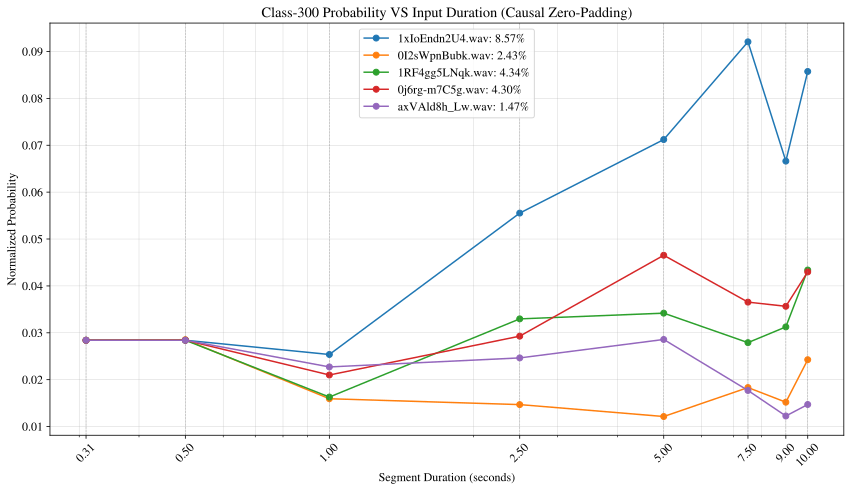

In [51]:
# Experiment 2
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0:segment_size]

        # Apply causal zero-padding to 10 seconds
        padding_size = (SAMPLING_RATE * 10) - segment_size
        if padding_size > 0:
            segment = np.pad(segment, (0, padding_size))
        else:
            segment = segment[:SAMPLING_RATE * 10]                              # Trim if segment exceeds 10 seconds

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TN_20_30[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration (Causal Zero-Padding)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_2_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_2_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples:   0%|          | 0/5 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))
Processing Samples: 100%|██████████| 5/5 [00:07<00:00,  1.41s/sample]


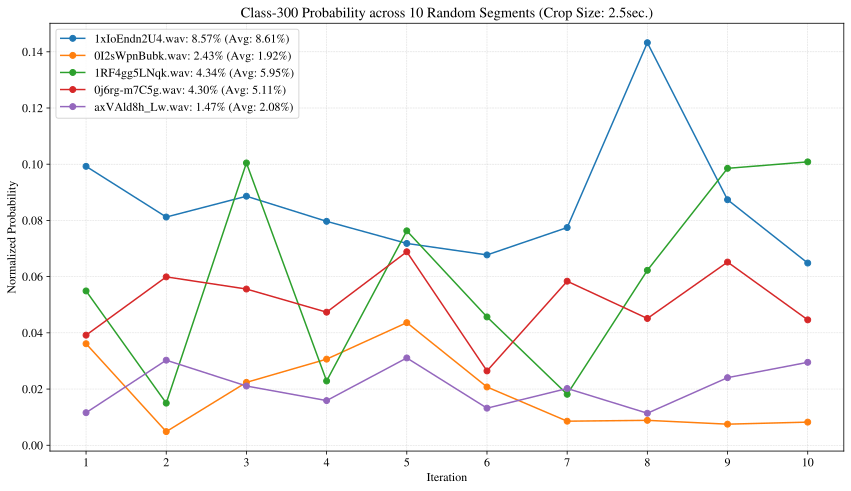

In [52]:
# Experiment 3
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        segment = sample[start_idx:start_idx + crop_size_samples]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TN_20_30[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, 11))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_3_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_3_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples: 100%|██████████| 5/5 [00:34<00:00,  6.80s/sample]


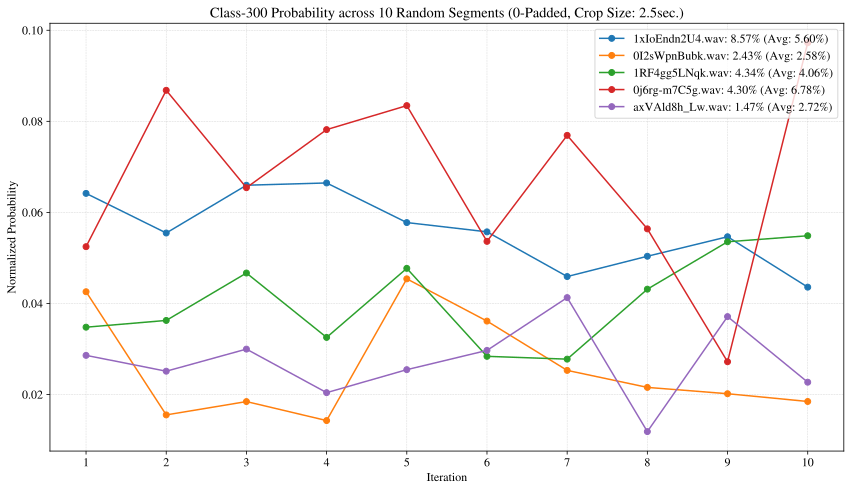

In [53]:
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        end_idx = start_idx + crop_size_samples

        # Extract the segment
        segment = sample[start_idx:end_idx]

        # Create a 10-second array filled with zeros
        zero_padded_array = np.zeros(sample_length, dtype=sample.dtype)

        # Insert the segment into the zero-padded array at the original position
        zero_padded_array[start_idx:end_idx] = segment

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(zero_padded_array).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TN_20_30[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, NUM_SEGMENTS + 1))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (0-Padded, Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_4_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_4_{GROUP_NAME}.svg", format="svg")
plt.show()

## TNs (31% < p < 50%)

In [ ]:
# Parameters
GROUP_NAME = 'TN_31_50'
TN_31_50 = ['0N5CxzxUPTA', 'D9QwDtohImc', '-S3QYp6JgBo', '-d7973HHglI', '-vGhwm5kWe0']
CLASS_INDEX = 300
SEGMENT_SIZES = [10., 9., 7.5, 5., 2.5, 1., 0.5, 0.31]                          # sec.
batch_size = len(TN_31_50)
size_samps = [int(size * SAMPLING_RATE) for size in SEGMENT_SIZES]

# Load audio samples
batch_samples, finetune_probs = load_samps_probs(base_dir=os.path.abspath('./'),
                                                 group_name=GROUP_NAME,
                                                 yt_ids=TN_31_50,
                                                 csv_filename='selected_samples.csv',
                                                 class_idx=CLASS_INDEX,
                                                 verbose=True)

In [ ]:
# Select sample to playback (0 - 4)
playback_idx = 0
Audio(batch_samples[playback_idx], rate=SAMPLING_RATE, normalize=False)

In [ ]:
# Experiment 1
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0: segment_size]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TN_31_50[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_1_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_1_{GROUP_NAME}.svg", format="svg")
plt.show()

In [ ]:
# Experiment 2
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0:segment_size]

        # Apply causal zero-padding to 10 seconds
        padding_size = (SAMPLING_RATE * 10) - segment_size
        if padding_size > 0:
            segment = np.pad(segment, (0, padding_size))
        else:
            segment = segment[:SAMPLING_RATE * 10]                              # Trim if segment exceeds 10 seconds

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TN_31_50[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration (Causal Zero-Padding)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_2_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_2_{GROUP_NAME}.svg", format="svg")
plt.show()

In [ ]:
# Experiment 3
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        segment = sample[start_idx:start_idx + crop_size_samples]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TN_31_50[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, 11))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_3_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_3_{GROUP_NAME}.svg", format="svg")
plt.show()

In [ ]:
# Experiment 4
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        end_idx = start_idx + crop_size_samples

        # Extract the segment
        segment = sample[start_idx:end_idx]

        # Create a 10-second array filled with zeros
        zero_padded_array = np.zeros(sample_length, dtype=sample.dtype)

        # Insert the segment into the zero-padded array at the original position
        zero_padded_array[start_idx:end_idx] = segment

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(zero_padded_array).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TN_31_50[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, NUM_SEGMENTS + 1))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (0-Padded, Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_4_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_4_{GROUP_NAME}.svg", format="svg")
plt.show()

## TNs MISS (p > 50%)

In [40]:
# Parameters
GROUP_NAME = 'TN_MISS'
TN_MISS = ['19zVANJXRJs', '2Jpg_KvJWL0', '1_k2BIxp_-w', '-r4V0QjlVrI', '0TtczPtxGwM']
CLASS_INDEX = 322
SEGMENT_SIZES = [10., 9., 7.5, 5., 2.5, 1., 0.5, 0.31]                          # sec.
batch_size = len(TN_MISS)
size_samps = [int(size * SAMPLING_RATE) for size in SEGMENT_SIZES]

# Load audio samples
batch_samples, finetune_probs = load_samps_probs(base_dir=os.path.abspath('./'),
                                                 group_name=GROUP_NAME,
                                                 yt_ids=TN_MISS,
                                                 csv_filename='selected_samples.csv',
                                                 class_idx=CLASS_INDEX,
                                                 verbose=True)

Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_MISS/19zVANJXRJs_Original.wav' for yt_id '19zVANJXRJs', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_MISS/2Jpg_KvJWL0_Original.wav' for yt_id '2Jpg_KvJWL0', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_MISS/1_k2BIxp_-w_Original.wav' for yt_id '1_k2BIxp_-w', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_MISS/-r4V0QjlVrI_Original.wav' for yt_id '-r4V0QjlVrI', Shape: (320000,), Sample Rate: 32000
Loaded '/content/drive/MyDrive/dottorato/ricerca/TecnoJest/analysis_phase_1_pre_embedding/selected_dataset/TN_MISS/0TtczPtxGwM_Original.wav' for yt_id '0TtczPtxGwM', Shape: (320000,), Samp

In [47]:
# Select sample to playback (0 - 4)
playback_idx = 4
Audio(batch_samples[playback_idx], rate=SAMPLING_RATE, normalize=False)

#Altri falsi positivi

Non contengono la label EV (e in effetti non contengono EV), ma sono stati classificati come EV

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:02<00:08,  2.16s/sample]


Processing Samples:  40%|████      | 2/5 [00:04<00:06,  2.17s/sample]


Processing Samples:  60%|██████    | 3/5 [00:06<00:04,  2.28s/sample]


Processing Samples:  80%|████████  | 4/5 [00:10<00:02,  2.87s/sample]


Processing Samples: 100%|██████████| 5/5 [00:16<00:00,  3.21s/sample]


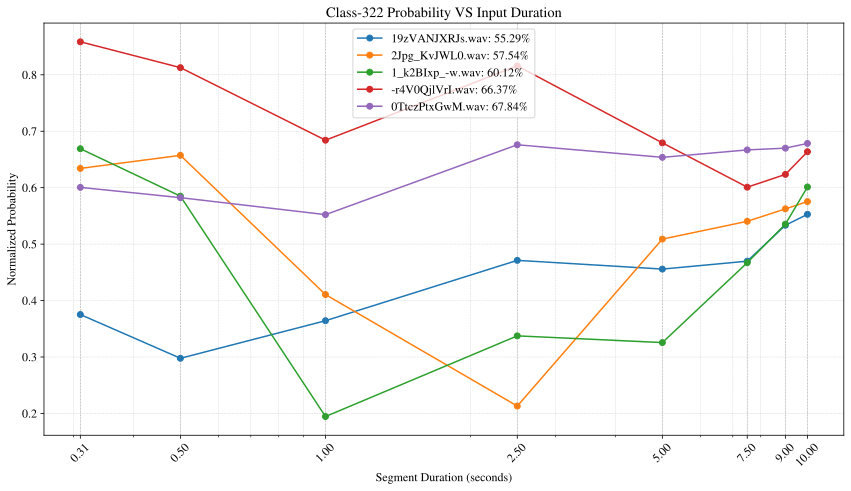

In [43]:
# Experiment 1
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0: segment_size]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TN_MISS[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration")
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_1_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_1_{GROUP_NAME}.svg", format="svg")
plt.show()

Sample 1: Segment Sizes:   0%|          | 0/8 [00:00<?, ?segment/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))

Processing Samples:  20%|██        | 1/5 [00:06<00:25,  6.31s/sample]


Processing Samples:  40%|████      | 2/5 [00:11<00:16,  5.60s/sample]


Processing Samples:  60%|██████    | 3/5 [00:16<00:10,  5.23s/sample]


Processing Samples:  80%|████████  | 4/5 [00:22<00:05,  5.72s/sample]


Processing Samples: 100%|██████████| 5/5 [00:27<00:00,  5.49s/sample]


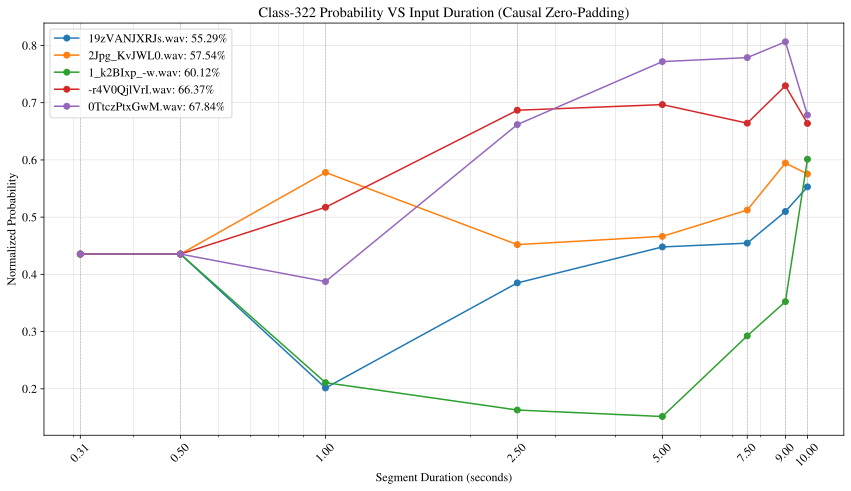

In [63]:
# Experiment 2
probabilities = {i: {size: [] for size in SEGMENT_SIZES} for i in range(batch_size)}

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    for segment_size in tqdm(size_samps, desc=f"Sample {sample_id + 1}: Segment Sizes", unit="segment", leave=False):

        # Crop input sample
        segment = sample[0:segment_size]

        # Apply causal zero-padding to 10 seconds
        padding_size = (SAMPLING_RATE * 10) - segment_size
        if padding_size > 0:
            segment = np.pad(segment, (0, padding_size))
        else:
            segment = segment[:SAMPLING_RATE * 10]                              # Trim if segment exceeds 10 seconds

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        probabilities[sample_id][segment_size / SAMPLING_RATE].append(class_probability)
    print()
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, results in probabilities.items():
    segment_sizes_sec = SEGMENT_SIZES
    probs = [results[size][0] for size in segment_sizes_sec]  # Access the first unique probability for each segment size
    plt.plot(segment_sizes_sec, probs, label=f"{TN_MISS[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}%", marker='o')
for segment_size in SEGMENT_SIZES:
    plt.axvline(segment_size, color='gray', linestyle='--', linewidth=0.6, alpha=0.5)

plt.xlabel("Segment Duration (seconds)")
plt.ylabel("Normalized Probability")
plt.xscale("log")
plt.xticks(SEGMENT_SIZES, labels=[f"{size:.2f}" for size in SEGMENT_SIZES], rotation=45)
plt.title(f"Class-{CLASS_INDEX} Probability VS Input Duration (Causal Zero-Padding)")
plt.grid(True, which="both", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_2_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_2_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples:   0%|          | 0/5 [00:00<?, ?sample/s]/usr/local/lib/python3.10/dist-packages/epanns_inference/models/models.py:241: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  clipwise_output = nn.functional.softmax(self.fc_audioset(x))
Processing Samples: 100%|██████████| 5/5 [00:06<00:00,  1.38s/sample]


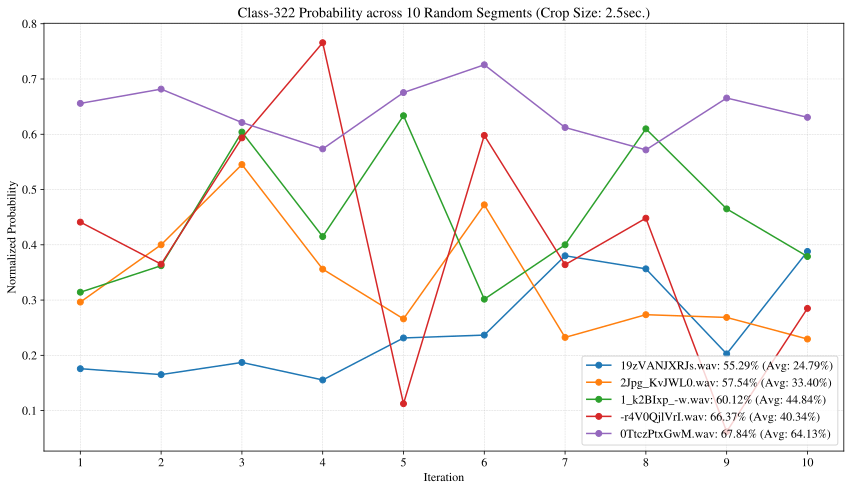

In [64]:
# Experiment 3
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        segment = sample[start_idx:start_idx + crop_size_samples]

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(segment).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TN_MISS[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, 11))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_3_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_3_{GROUP_NAME}.svg", format="svg")
plt.show()

Processing Samples: 100%|██████████| 5/5 [00:34<00:00,  6.85s/sample]


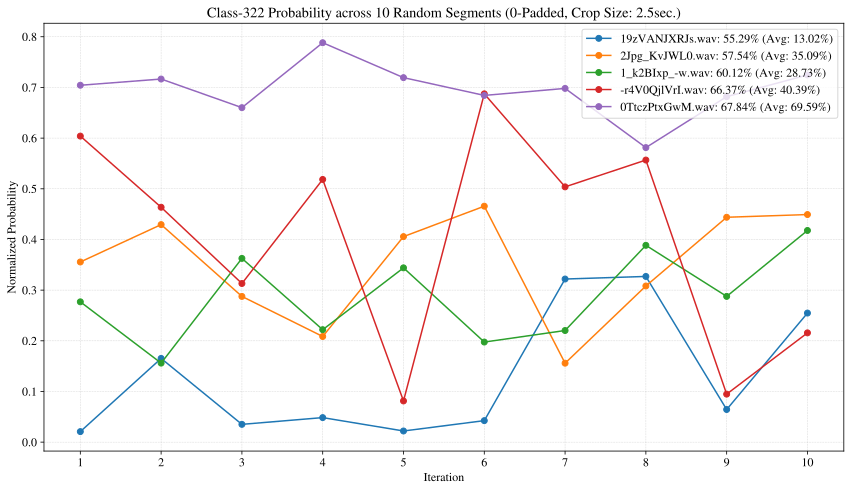

In [65]:
# Experiment 4
CROP_SIZE = 2.5  # Segment duration in seconds
NUM_SEGMENTS = 10  # Number of random segments to extract per sample
np.random.seed(RANDOM_SEED)

crop_size_samples = int(CROP_SIZE * SAMPLING_RATE)  # Convert crop size to samples
probabilities = {i: [] for i in range(batch_size)}  # Store probabilities for each sample

for sample_id, sample in enumerate(tqdm(batch_samples, desc="Processing Samples", unit="sample")):
    sample_length = len(sample)
    segment_probs = []

    for _ in range(NUM_SEGMENTS):
        # Randomly select a start point for the segment
        start_idx = np.random.randint(0, sample_length - crop_size_samples + 1)
        end_idx = start_idx + crop_size_samples

        # Extract the segment
        segment = sample[start_idx:end_idx]

        # Create a 10-second array filled with zeros
        zero_padded_array = np.zeros(sample_length, dtype=sample.dtype)

        # Insert the segment into the zero-padded array at the original position
        zero_padded_array[start_idx:end_idx] = segment

        # Convert to Torch.Tensor (adding batch dim)
        segment_tensor = torch.tensor(zero_padded_array).unsqueeze(0).float().to(DEVICE)

        # Inference
        with torch.no_grad():
            model.eval()
            output = model(segment_tensor)

        # Extract specific class probability
        class_probability = output['clipwise_output'].squeeze()[CLASS_INDEX].item()
        segment_probs.append(class_probability)

    probabilities[sample_id] = segment_probs  # Store all segment probabilities for this sample
print("\n" * 2, end="")

# Plot
plt.figure(figsize=(12, 7))

for sample_id, segment_probs in probabilities.items():
    avg_prob = np.mean(segment_probs) * 100.  # Compute the average probability for this sample
    plt.plot(range(1, NUM_SEGMENTS + 1), segment_probs, label=f"{TN_MISS[sample_id]}.wav: {finetune_probs[sample_id] * 100:.2f}% (Avg: {avg_prob:.2f}%)", marker='o')

plt.xlabel("Iteration")
plt.ylabel("Normalized Probability")
plt.xticks(range(1, NUM_SEGMENTS + 1))
plt.title(f"Class-{CLASS_INDEX} Probability across {NUM_SEGMENTS} Random Segments (0-Padded, Crop Size: {CROP_SIZE}sec.)")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"experiment_4_{GROUP_NAME}.png", format="png")
plt.savefig(f"experiment_4_{GROUP_NAME}.svg", format="svg")
plt.show()

#RT simulation
1. Circular Buffer:
  - Writing Pointer (WP): Continuously writes audio samples into the circular buffer at 32000Hz sampling rate in a non-blocking loop (thanks to threads). Manages a semaphore to signal the IFP when a write has been completed.
  - Input Frame Provider (IFP): Reads frames of audio data from the buffer in the past (backwards w.r.t. WP), ensuring
    - a minimum frame length of 310ms (about 9920 samples)
    - the samples already read are not read again
    - the width of the input frame is regulated by the inference latency
    - the width of the input frame is regulated also by the adaptive mechanism (see below).

2. Frame Inference:

  - The frame read by the RP is passed to the e-panns model for one-class inference which runs on a separate thread.
  - The inference output is saved in an output buffer.
  - A semaphore or signaling mechanism is used to indicate when the inference result is ready.

3. Adaptive Mechanism:

  - The length of the frame read by the RP can increase up to X seconds if the probability of class 322 (from the inference output) is ≥ p.

4. Simulation:

  - The implementation will simulate the described system without real-time constraints for now.

## Import





In [3]:
import threading
import numpy as np
import time
import matplotlib.pyplot as plt
import logging

## Circular Buffer Class with Thread safe Read/Write

In [4]:
class CircularBuffer:
    def __init__(self, size):
        """
        Initialize a circular buffer.

        Args:
            size (int): The size of the circular buffer in samples.
        """
        self.buffer = np.zeros(size, dtype=np.float32)
        self.size = size
        self.lock = threading.Lock()  # To ensure thread-safe access
        self.write_pointer = 0
        self.semaphore = threading.Semaphore(0)  # Semaphore to signal new writes

    def write(self, data):
        """
        Write data into the circular buffer.

        Args:
            data (np.ndarray): Array of data to write into the buffer.
        """
        with self.lock:
            data_len = len(data)
            if data_len > self.size:
                raise ValueError("Data length exceeds buffer size!")

            end_pos = (self.write_pointer + data_len) % self.size
            if self.write_pointer + data_len <= self.size:
                self.buffer[self.write_pointer:self.write_pointer + data_len] = data
            else:
                split = self.size - self.write_pointer
                self.buffer[self.write_pointer:] = data[:split]
                self.buffer[:end_pos] = data[split:]
            self.write_pointer = end_pos

        self.semaphore.release()  # Signal that new data is available

    def read(self, start_pos, frame_size):
        """
        Read a frame from the circular buffer.

        Args:
            start_pos (int): Starting position of the frame in the buffer.
            frame_size (int): Number of samples to read.

        Returns:
            np.ndarray: The extracted frame.
        """
        with self.lock:
            end_pos = (start_pos + frame_size) % self.size
            if start_pos + frame_size <= self.size:
                return self.buffer[start_pos:start_pos + frame_size]
            else:
                split = self.size - start_pos
                return np.concatenate((self.buffer[start_pos:], self.buffer[:end_pos]))

    def debug_state(self):
        """
        Print the current state of the buffer for debugging.
        """
        with self.lock:
            logging.info(f"Buffer state: {self.buffer}")
            logging.info(f"Write pointer: {self.write_pointer}")


##Writing Pointer Thread

In [5]:
def write_to_buffer(buffer, audio_data, sampling_rate, chunk_duration):
    """
    Simulates real-time writing of audio data to the circular buffer.

    Args:
        buffer (CircularBuffer): The circular buffer to write to.
        audio_data (np.ndarray): The audio data to simulate input from.
        sampling_rate (int): The sampling rate of the audio (samples per second).
        chunk_duration (float): The duration of each chunk in seconds.
    """
    audio_index = 0  # Tracks the current position in the audio data
    chunk_size = int(sampling_rate * chunk_duration)  # Calculate chunk size in samples

    try:
        while audio_index < len(audio_data):
            # Extract the next chunk of audio samples
            chunk = audio_data[audio_index:audio_index + chunk_size]

            # Write the chunk to the circular buffer
            buffer.write(chunk)
            logging.info(f"Writing chunk: start_index={audio_index}, chunk_size={len(chunk)}, write_pointer={buffer.write_pointer}")

            # Advance the index in the audio data
            audio_index += chunk_size

            # Simulate real-time delay
            time.sleep(chunk_duration)
    except Exception as e:
        logging.error(f"Error in writing thread: {e}")


##Input Frame Provider

In [6]:
class InputFrameProvider:
    def __init__(self, buffer, frame_duration_min, frame_duration_max, sampling_rate):
        """
        Provides frames for inference from a circular buffer.

        Args:
            buffer (CircularBuffer): The circular buffer instance.
            frame_duration_min (float): Minimum frame duration (seconds).
            frame_duration_max (float): Maximum frame duration (seconds).
            sampling_rate (int): Sampling rate of the audio (samples per second).
        """
        self.buffer = buffer
        self.sampling_rate = sampling_rate
        self.frame_size_min = int(frame_duration_min * sampling_rate)
        self.frame_size_max = int(frame_duration_max * sampling_rate)
        self.start_pos = 0
        self.frame_size = self.frame_size_min  # Initialize to minimum frame size

    def get_frame(self, adapt_width):
        """
        Retrieves a frame from the circular buffer.

        Args:
            adapt_width (bool): Whether to adaptively increase frame size.

        Returns:
            tuple: A tuple containing:
                - frame (np.ndarray): The retrieved frame or an empty frame if invalid.
                - is_valid (bool): Whether the frame is valid.
        """
        self.buffer.semaphore.acquire()  # Wait for a signal from the writing thread

        write_pointer = self.buffer.write_pointer

        # Compute the actual frame size based on WP and SP, considering wrapping
        act_frame_size = (write_pointer - self.start_pos) % self.buffer.size
        logging.info(f"Computed frame size: {act_frame_size}, current frame size: {self.frame_size}, min size: {self.frame_size_min}")

        # Validate the frame size
        if (self.frame_size > act_frame_size) or (act_frame_size < self.frame_size_min):
            # Invalid frame size, return empty frame and False
            logging.warning(f"Invalid frame: WP={write_pointer}, SP={self.start_pos}, act_frame_size={act_frame_size}, frame_size={self.frame_size}")
            return np.zeros(self.frame_size, dtype=np.float32), False

        # Read the frame from the circular buffer
        frame = self.buffer.read(self.start_pos, act_frame_size)

        # Update start_pos
        self.start_pos = (self.start_pos + act_frame_size) % self.buffer.size

        # Adaptive frame size adjustment
        if adapt_width:
            self.frame_size = min(self.frame_size + self.sampling_rate // 2, self.frame_size_max)
        else:
            self.frame_size = act_frame_size  # Sync frame size with actual size

        # Debug logging
        logging.info(f"Valid frame: WP={write_pointer}, SP={self.start_pos}, act_frame_size={act_frame_size}, frame_size={self.frame_size}")

        return frame, True


##Inference Task Thread

In [7]:
def inference_task(event, frame_provider, results, output_threshold=0.5):
    """
    Simulates a real-time inference task using frames provided by InputFrameProvider.

    Args:
        event (threading.Event): Signal to stop the inference task.
        frame_provider (InputFrameProvider): Provides frames for inference.
        results (list): Shared list to store inference results.
        output_threshold (float): Threshold to enable adaptive frame sizing.
    """
    try:
        while not event.is_set():
            # Determine adapt_width based on the latest inference result
            adapt_width = results and results[-1] >= output_threshold

            # Fetch a frame with the determined adapt_width
            frame, is_valid = frame_provider.get_frame(adapt_width=adapt_width)

            if not is_valid:
                # Handle invalid frame case
                logging.warning("Invalid frame received. Skipping inference.")
                time.sleep(0.1)  # Short wait before retrying
                continue

            # Perform (mock) inference
            mock_result = 0.4  # Replace with dynamic result if needed
            results.append(mock_result)

            # Log inference results
            logging.info(f"Inference result: {mock_result}, adapt_width: {adapt_width}, frame size: {len(frame)}")

            # Simulate inference time
            time.sleep(0.1)
    except Exception as e:
        logging.error(f"Inference task error: {e}")


## Main Simulation Loop

In [ ]:
if __name__ == "__main__":
    # Parameters
    sampling_rate = 32000
    frame_duration_min = 0.310  # Minimum frame duration (seconds)
    frame_duration_max = 2.0    # Maximum frame duration (seconds)
    buffer_duration = 2.0       # Buffer duration (seconds)
    chunk_duration = 0.310      # Duration of audio chunks to be written (seconds)
    total_duration = 5.0        # Total simulation duration (seconds)
    output_threshold = 0.5      # Adaptive width threshold

    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )

    # Derived Parameters
    buffer_size = int(buffer_duration * sampling_rate)
    chunk_size = int(chunk_duration * sampling_rate)

    logging.info(f"Buffer size: {buffer_size} samples")
    logging.info(f"Chunk size: {chunk_size} samples")
    logging.info(f"Total audio samples: {int(total_duration * sampling_rate)}")

    # Generate audio data (sine wave at 1 Hz)
    audio_data = np.sin(2 * np.pi * 1 * np.linspace(0, total_duration, int(total_duration * sampling_rate)))

    # Ensure audio data is long enough
    if len(audio_data) < buffer_size:
        raise ValueError("Audio data is too short for the specified simulation duration.")

    # Initialize components
    circular_buffer = CircularBuffer(buffer_size)
    frame_provider = InputFrameProvider(circular_buffer, frame_duration_min, frame_duration_max, sampling_rate)
    inference_event = threading.Event()
    inference_results = []

    # Start threads
    wp_thread = threading.Thread(target=write_to_buffer, args=(circular_buffer, audio_data, sampling_rate, chunk_duration))
    inference_thread = threading.Thread(target=inference_task, args=(inference_event, frame_provider, inference_results, output_threshold))

    logging.info("Starting threads...")

    wp_thread.start()
    inference_thread.start()

    # Run simulation for the total duration
    try:
        logging.info(f"Simulation running for {total_duration} seconds...")
        time.sleep(total_duration)
    except KeyboardInterrupt:
        logging.warning("Simulation interrupted by user.")
    except Exception as e:
        logging.error(f"Unexpected error during simulation: {e}")
    finally:
        # Stop threads
        inference_event.set()
        wp_thread.join()
        inference_thread.join()

    # Display final results
    logging.info("Simulation completed. Visualizing results...")
    plt.figure(figsize=(10, 6))
    plt.plot(inference_results, label="Inference Output", marker="o", linestyle="-")
    plt.axhline(y=output_threshold, color='r', linestyle='--', label="Threshold")
    plt.xlabel("Inference Steps")
    plt.ylabel("Probability")
    plt.title("Inference Results Over Time")
    plt.legend()
    plt.grid()
    plt.show()


## Full Simulation Test 1

Buffer size: 64000 samples
Inference result: 0.4, adapt_width: [0.4], frame size: 9920Simulation running for 5.0 seconds...

Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width: False, frame size: 9920
Inference result: 0.4, adapt_width:

Invalid frame received. Skipping inference.
Reconstructed signal does not match the original audio data. Check for errors.


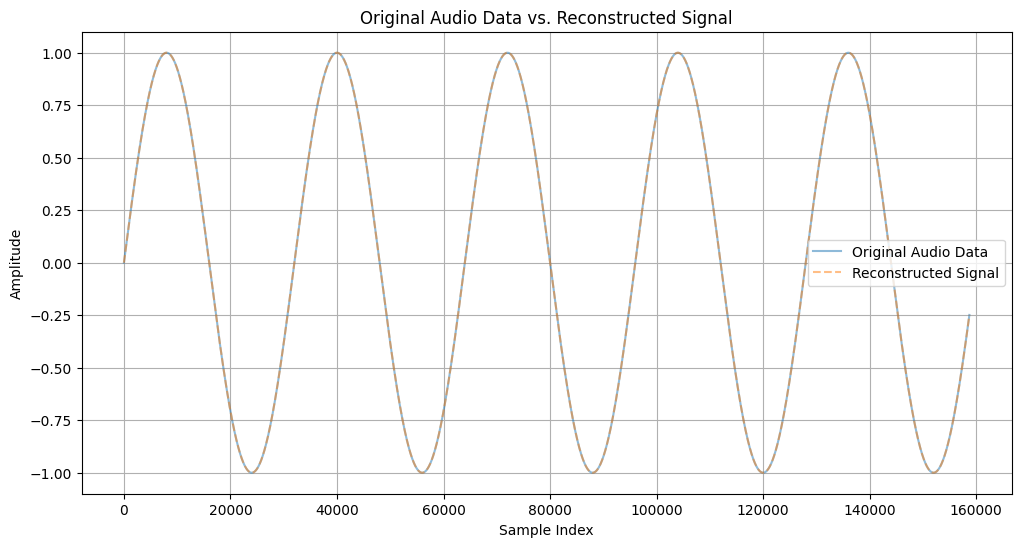

In [8]:
if __name__ == "__main__":
    # Parameters
    sampling_rate = 32000
    frame_duration_min = 0.310  # Minimum frame duration (seconds)
    frame_duration_max = 1.0    # Maximum frame duration (seconds)
    buffer_duration = 2.0       # Buffer duration (seconds)
    chunk_duration = 0.310        # Duration of audio chunks to be written (seconds)
    total_duration = 5.0        # Total simulation duration (seconds)
    output_threshold = 0.5      # Adaptive width threshold

    # Derived Parameters
    buffer_size = int(buffer_duration * sampling_rate)
    print(f"Buffer size: {buffer_size} samples")
    audio_data = np.sin(2 * np.pi * 1 * np.linspace(0, total_duration, int(total_duration * sampling_rate)))

    # Ensure audio data is long enough
    if len(audio_data) < buffer_size:
        raise ValueError("Audio data is too short for the specified simulation duration.")

    # Initialize components
    circular_buffer = CircularBuffer(buffer_size)
    frame_provider = InputFrameProvider(circular_buffer, frame_duration_min, frame_duration_max, sampling_rate)
    inference_event = threading.Event()
    inference_results = []
    reconstructed_frames = []  # Store frames read during inference

    def inference_task_with_frame_collection(event, frame_provider, results, reconstructed_frames, output_threshold=0.5):
        """
        Extended inference task to collect frames in real-time.
        """
        try:
            while not event.is_set():
                # Determine adapt_width based on the latest inference result
                adapt_width = results and results[-1] >= output_threshold

                # Fetch a frame with the determined adapt_width
                frame, is_valid = frame_provider.get_frame(adapt_width=adapt_width)

                if not is_valid:
                    # Handle invalid frame case
                    print("Invalid frame received. Skipping inference.")
                    time.sleep(0.05)  # Short wait before retrying
                    continue

                # Perform (mock) inference
                mock_result = 0.4  # Replace with dynamic result if needed
                results.append(mock_result)

                # Collect the frame for reconstruction
                reconstructed_frames.append(frame)

                # Debugging output
                print(f"Inference result: {mock_result}, adapt_width: {adapt_width}, frame size: {len(frame)}")

                # Simulate inference time
                time.sleep(0.1)
        except Exception as e:
            print(f"Inference task error: {e}")

    # Start threads
    wp_thread = threading.Thread(target=write_to_buffer, args=(circular_buffer, audio_data, sampling_rate, chunk_duration))
    inference_thread = threading.Thread(target=inference_task_with_frame_collection,
                                         args=(inference_event, frame_provider, inference_results, reconstructed_frames, output_threshold))

    wp_thread.start()
    inference_thread.start()

    # Run simulation for the total duration
    try:
        print(f"Simulation running for {total_duration} seconds...")
        time.sleep(total_duration)
    except KeyboardInterrupt:
        print("Simulation interrupted by user.")
    finally:
        # Stop threads
        inference_event.set()
        wp_thread.join()
        inference_thread.join()

    # Reconstruct the signal
    reconstructed_signal = np.concatenate(reconstructed_frames)

    # Trim audio_data for comparison
    audio_data_trimmed = audio_data[:len(reconstructed_signal)]

    # Validate the reconstruction
    if np.allclose(reconstructed_signal, audio_data_trimmed):
        print("Reconstructed signal matches the original audio data!")
    else:
        print("Reconstructed signal does not match the original audio data. Check for errors.")

    # Visualization
    plt.figure(figsize=(12, 6))

    # Original Audio Data
    plt.plot(audio_data_trimmed, label="Original Audio Data", alpha=0.5)

    # Reconstructed Signal
    plt.plot(reconstructed_signal, label="Reconstructed Signal", linestyle="--", alpha=0.5)

    plt.title("Original Audio Data vs. Reconstructed Signal")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid()
    plt.show()


## Full Simulation Test 2

INFO:root:Starting system integration test...
INFO:root:Writing chunk: start_index=0, chunk_size=9920, write_pointer=9920
INFO:root:Computed frame size: 9920, current frame size: 9920, min size: 9920
INFO:root:Simulation running for 5.0 seconds...
INFO:root:Valid frame: WP=9920, SP=9920, act_frame_size=9920, frame_size=9920
INFO:root:Inference result: 0.4, adapt_width: [0.4], frame size: 9920
INFO:root:Writing chunk: start_index=9920, chunk_size=9920, write_pointer=19840
INFO:root:Computed frame size: 9920, current frame size: 9920, min size: 9920
INFO:root:Valid frame: WP=19840, SP=19840, act_frame_size=9920, frame_size=9920
INFO:root:Inference result: 0.4, adapt_width: False, frame size: 9920
INFO:root:Writing chunk: start_index=19840, chunk_size=9920, write_pointer=29760
INFO:root:Computed frame size: 9920, current frame size: 9920, min size: 9920
INFO:root:Valid frame: WP=29760, SP=29760, act_frame_size=9920, frame_size=9920
INFO:root:Inference result: 0.4, adapt_width: False, fram

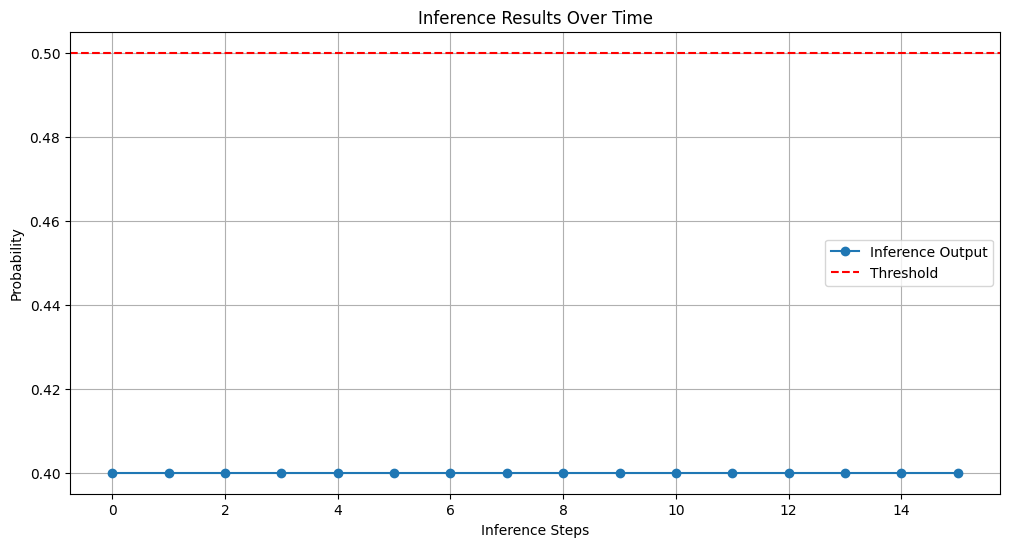

In [14]:
def full_simulation_test():
    # Parameters
    sampling_rate = 32000
    frame_duration_min = 0.310  # Minimum frame duration (seconds)
    frame_duration_max = 2.0    # Maximum frame duration (seconds)
    buffer_duration = 2.0       # Buffer duration (seconds)
    chunk_duration = 0.310      # Duration of audio chunks to be written (seconds)
    total_duration = 5.0        # Total simulation duration (seconds)
    output_threshold = 0.5      # Adaptive width threshold

    # Configure logging
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    logging.getLogger().setLevel(logging.DEBUG)

    # Derived parameters
    buffer_size = int(buffer_duration * sampling_rate)
    audio_data = np.sin(2 * np.pi * 1 * np.linspace(0, total_duration, int(total_duration * sampling_rate)))

    # Ensure audio data is long enough
    if len(audio_data) < buffer_size:
        raise ValueError("Audio data is too short for the specified simulation duration.")

    # Initialize components
    circular_buffer = CircularBuffer(buffer_size)
    frame_provider = InputFrameProvider(circular_buffer, frame_duration_min, frame_duration_max, sampling_rate)
    inference_event = threading.Event()
    inference_results = []

    # Start threads
    wp_thread = threading.Thread(target=write_to_buffer, args=(circular_buffer, audio_data, sampling_rate, chunk_duration))
    inference_thread = threading.Thread(target=inference_task, args=(inference_event, frame_provider, inference_results, output_threshold))

    logging.info("Starting system integration test...")
    wp_thread.start()
    inference_thread.start()

    # Run simulation
    try:
        logging.info(f"Simulation running for {total_duration} seconds...")
        time.sleep(total_duration)
    except Exception as e:
        logging.error(f"Simulation interrupted: {e}")
    finally:
        # Stop threads
        inference_event.set()
        wp_thread.join()
        inference_thread.join()

    # Explicitly release the semaphore to unblock get_frame calls
    frame_count = min(len(inference_results), circular_buffer.size // frame_provider.frame_size_min)
    for _ in range(frame_count):
        circular_buffer.semaphore.release()

    # Verify results
    logging.info("Simulation completed. Analyzing results...")
    reconstructed_frames = []
    for i in range(frame_count):
        frame, is_valid = frame_provider.get_frame(False)
        if is_valid:
            reconstructed_frames.append(frame)
        else:
            logging.warning(f"Frame {i} is invalid.")

    if reconstructed_frames:
        reconstructed_signal = np.concatenate(reconstructed_frames)
        # Validate reconstruction
        audio_trimmed = audio_data[:len(reconstructed_signal)]
        if np.allclose(reconstructed_signal, audio_trimmed):
            logging.info("Reconstructed signal matches original audio!")
        else:
            logging.warning("Reconstructed signal does not match original audio. Check for errors.")
    else:
        logging.error("No frames were reconstructed. Check system behavior.")
        reconstructed_signal = np.array([])  # Empty signal for safety


    # Visualize results
    plt.figure(figsize=(12, 6))
    plt.plot(inference_results, label="Inference Output", marker="o", linestyle="-")
    plt.axhline(y=output_threshold, color='r', linestyle='--', label="Threshold")
    plt.title("Inference Results Over Time")
    plt.xlabel("Inference Steps")
    plt.ylabel("Probability")
    plt.legend()
    plt.grid()
    plt.show()

    # Run the full simulation test
if __name__ == "__main__":
    full_simulation_test()
